<a href="https://colab.research.google.com/github/jianlgler/IST_labiagi/blob/main/PyTorch_AdaIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm
from google.colab import drive
import numpy as np
import os
import sys

Instance Normalization normalizza l'input su un singolo stile specifico. Qui si propone la Adaptive Instance Normalization, dove stile e contenuto sono parametrici. Notare che non ci sono parametri learnable, la funzione stessa li computa dallo style input.

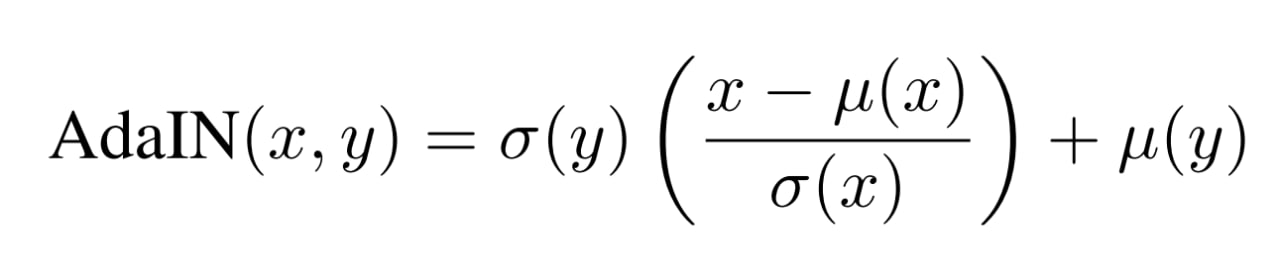

In [3]:
def calc_mean_std(input, eps=1e-5):
  assert (len(input.size) == 4)

  batch_size, channels = input.shape[:2]

  reshaped = input.view(batch_size, channels, -1) # Reshape channel wise
  mean = torch.mean(reshaped, dim = 2).view(batch_size, channels, 1, 1) # Calculat mean and reshape
  std = torch.sqrt(torch.var(reshaped, dim=2)+eps).view(batch_size, channels, 1, 1) # Calculate variance, add epsilon (avoid 0 division),
                                                                                    # calculate std and reshape
  return mean, std

def ada_in(content_features, style_features):
  assert content_features.shape[:2] == style_features.shape[:2] # Only first two dim, such that different image sizes is possible

  style_mean, style_std = calc_mean_std(style_features)
  content_mean, content_std = calc_mean_std(content_features)

  output = style_std*((content_features - content_mean) / (content_std)) + style_mean


Content and Style Loss

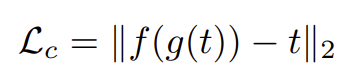

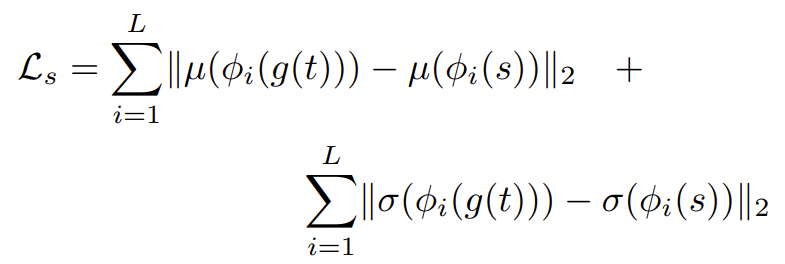

In [7]:
def content_loss(input, target): # Content loss is a simple MSE Loss
  assert (input.size() == target.size())
  assert (target.requires_grad is False)
  return F.mse_loss(input, target)
  
def style_loss(input, target):
  assert (input.size() == target.size())
  assert (target.requires_grad is False)

  input_mean, input_std = calc_mean_std(input)
  target_mean, target_std = calc_mean_std(target)

  return F.mse_loss(input_mean, target_mean) +  F.mse_loss(input_std, target_std)